In [1]:
from data import create_spiral
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class SpiralModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linearA = nn.Linear(in_features=2, out_features=3)
        self.linear1 = nn.Linear(in_features=2, out_features=10)
        self.linear2 = nn.Linear(in_features=10, out_features=10)
        self.linear3 = nn.Linear(in_features=10, out_features=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linearA(x)
        # return self.linear3(self.relu(self.linear1(x)))
        # return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

In [4]:
X, y = create_spiral(N=500, theta=0.2)
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)  # features as float32
y = torch.from_numpy(y).type(torch.LongTensor)  # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)

In [6]:
loss_fn = nn.CrossEntropyLoss()
epochs = 100
NUM_OF_MODELS = 500
single_layer_models =[]
for model in range(NUM_OF_MODELS):
    model_1 = SpiralModel().to(device)
    optimizer = torch.optim.Adam(model_1.parameters(), lr=0.02)
    # Loop over data
    for epoch in range(epochs):
        ## Training
        model_1.train()
        # 1. forward pass
        y_logits = model_1(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # 2. calculate the loss
        loss = loss_fn(y_logits, y_train)
        acc = acc_fn(y_pred, y_train)

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backwards
        loss.backward()

        # 5. optimizer step step step
        optimizer.step()

        ## Testing
        model_1.eval()
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model_1(X_test)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            # 2. Caculate loss and acc
            test_loss = loss_fn(test_logits, y_test)
            test_acc = acc_fn(test_pred, y_test)

        # Print out what's happening
        if model % 50 == 0:
            if epoch % 99 == 0:
                print(
                    f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}"
                )
    single_layer_models.append(model_1.state_dict())
    

Epoch: 0 | Loss: 1.18 Acc: 0.33 | Test loss: 1.20 Test acc: 0.26
Epoch: 99 | Loss: 0.78 Acc: 0.53 | Test loss: 0.81 Test acc: 0.51
Epoch: 0 | Loss: 1.11 Acc: 0.27 | Test loss: 1.09 Test acc: 0.29
Epoch: 99 | Loss: 0.78 Acc: 0.52 | Test loss: 0.80 Test acc: 0.51
Epoch: 0 | Loss: 1.19 Acc: 0.31 | Test loss: 1.21 Test acc: 0.30
Epoch: 99 | Loss: 0.80 Acc: 0.53 | Test loss: 0.84 Test acc: 0.50
Epoch: 0 | Loss: 1.22 Acc: 0.30 | Test loss: 1.23 Test acc: 0.28
Epoch: 99 | Loss: 0.79 Acc: 0.53 | Test loss: 0.82 Test acc: 0.50
Epoch: 0 | Loss: 1.31 Acc: 0.23 | Test loss: 1.27 Test acc: 0.29
Epoch: 99 | Loss: 0.79 Acc: 0.52 | Test loss: 0.81 Test acc: 0.51
Epoch: 0 | Loss: 1.07 Acc: 0.47 | Test loss: 1.09 Test acc: 0.45
Epoch: 99 | Loss: 0.76 Acc: 0.52 | Test loss: 0.79 Test acc: 0.51
Epoch: 0 | Loss: 1.15 Acc: 0.34 | Test loss: 1.12 Test acc: 0.41
Epoch: 99 | Loss: 0.80 Acc: 0.53 | Test loss: 0.83 Test acc: 0.50
Epoch: 0 | Loss: 1.24 Acc: 0.22 | Test loss: 1.24 Test acc: 0.17
Epoch: 99 | Loss: 

In [7]:
import pickle

with open("1_layer_models.pickle", "wb") as f:
    pickle.dump(single_layer_models, f)
    print("Saved trained models")

Saved trained models


In [8]:
def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

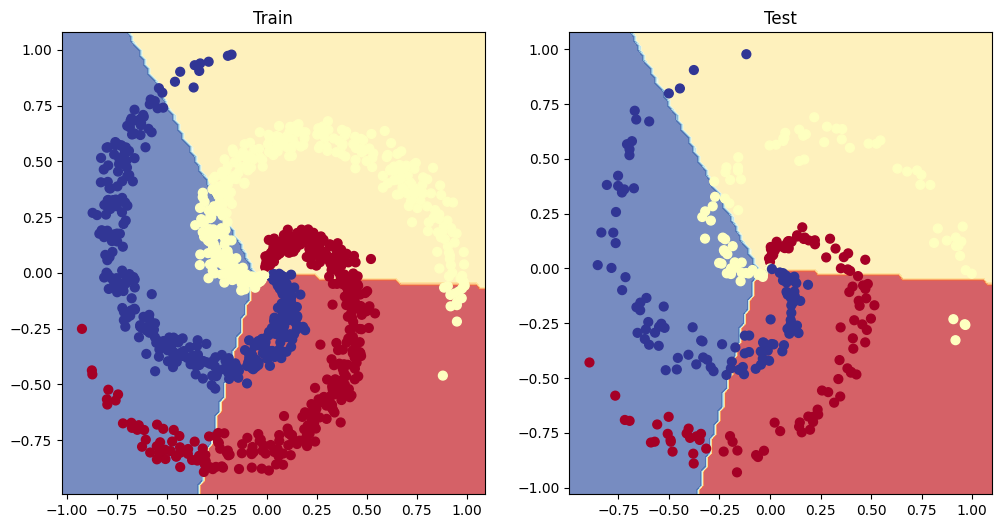

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [15]:
state_dict = single_layer_models[0]
model_test = SpiralModel().to(device)
model_test.load_state_dict(state_dict)
model_test.eval()
with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_test(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_acc = acc_fn(test_pred, y_test)
print(test_acc.item())

0.5133333206176758
